In [4]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
from datasets import Dataset

In [5]:
data = pd.read_csv('./data/clothing-dataset/images.csv').set_index('image')
data.tail()

,sender_id,label,kids
image,,,
dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False
32b99302-cec7-4dec-adfa-3d4029674209,204,Skirt,False


# Model performance on the test data only

In [6]:
def get_neighbours(img_index,n,collection_name):
    img_response = requests.get('http://localhost:6333/collections/{}/points/'.format(collection_name)+str(img_index))
    search_obj = {
        "filter": {
        },
        "params": {
            "hnsw_ef": 128
        },
        "vector": img_response.json()['result']['vector'],
        "top": n+1
    }
    search_response = requests.post('http://localhost:6333/collections/{}/points/search'.format(collection_name), json=search_obj)
    neighbours = []
    for item in search_response.json()['result']:
        if (len(neighbours) < n) & (item['id'] != img_index):
            neighbours.append(item['id'])
    return {"neighbours": neighbours}

In [7]:
def metric_evaluation(collection_name,n):
    neighbours_labels_same = []
    for img_ind in range(0,len(img_ids)):  
        closest_ind = get_neighbours(img_ind,n,collection_name)['neighbours']
        for ind in closest_ind:
            if data.loc[img_ids[ind]]['label']==data.loc[img_ids[img_ind]]['label']:
                neighbours_labels_same.append(1)
            else:
                neighbours_labels_same.append(0)
    return sum(neighbours_labels_same)/len(neighbours_labels_same)

In [84]:
with open('./Model evaluation/vectors_one_layer_pretrained.json') as jsonFile:
    vectors = json.load(jsonFile)
    jsonFile.close()
img_ids = list(vectors.keys())

In [85]:
len(img_ids)

904

In [86]:
len(vectors[img_ids[0]])

768

In [8]:
#Install Qdrant with Docker https://qdrant.tech/documentation/install/

In [87]:
collection_name = "test_collection_one_layer_pretrained"
collection_obj = {
    "create_collection": {
        "name": collection_name,
        "distance": "Cosine",
        "vector_size": 768
    }
}
x = requests.post('http://localhost:6333/collections', json = collection_obj)

In [88]:
for i in range(0,len(vectors)):
    point_obj = {
            "upsert_points": {
                "points": [
                    {
                        "id": i,
                        "payload": {},
                        "vector": vectors[img_ids[i]]
                    }
                ]
            }
        }
    x = requests.post('http://localhost:6333/collections/'+collection_name, json = point_obj)

In [89]:
metric_table = {}
for n in range(1,6):
    metric_table[n]=metric_evaluation(collection_name,n)

In [90]:
metric_table

{1: 0.6150442477876106,
 2: 0.5846238938053098,
 3: 0.5763274336283186,
 4: 0.5710730088495575,
 5: 0.5665929203539823}

In [91]:
with open('./Model evaluation/vectors_one_layer_tuned.json') as jsonFile:
    vectors = json.load(jsonFile)
    jsonFile.close()
img_ids = list(vectors.keys())

In [92]:
len(img_ids)

904

In [93]:
len(vectors[img_ids[0]])

768

In [94]:
collection_name = "test_collection_one_layer_tuned"
collection_obj = {
    "create_collection": {
        "name": collection_name,
        "distance": "Cosine",
        "vector_size": 768
    }
}
x = requests.post('http://localhost:6333/collections', json = collection_obj)

In [95]:
for i in range(0,len(vectors)):
    point_obj = {
            "upsert_points": {
                "points": [
                    {
                        "id": i,
                        "payload": {},
                        "vector": vectors[img_ids[i]]
                    }
                ]
            }
        }
    x = requests.post('http://localhost:6333/collections/'+collection_name, json = point_obj)

In [96]:
metric_table = {}
for n in range(1,11):
    metric_table[n]=metric_evaluation(collection_name,n)

In [97]:
metric_table

{1: 0.8451327433628318,
 2: 0.8324115044247787,
 3: 0.8370206489675516,
 4: 0.8373893805309734,
 5: 0.8338495575221239}

# Checking neighbours

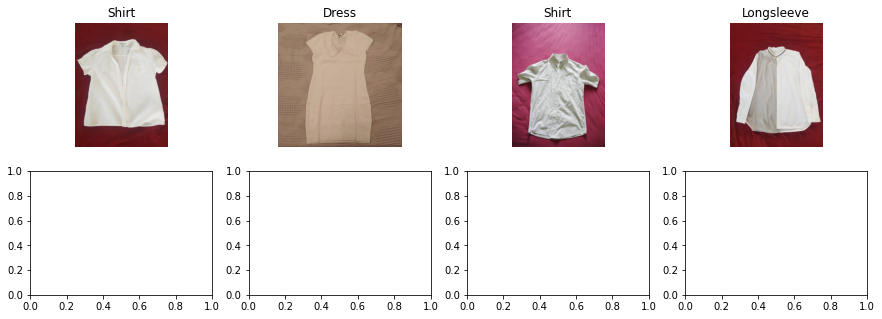

In [83]:
img_ind_selected = 1
collection_name = "test_collection_one_layer_tuned"

neighbours_ind = get_neighbours(img_ind_selected,3,collection_name)['neighbours']
neighbours_ind.insert(0,img_ind_selected)

f, ax = plt.subplots(2,4, figsize=(15,5))
for i, ind in enumerate(neighbours_ind):
    img_id = img_ids[ind]
    path = os.path.join('./project/data/clothing-dataset/images', img_id+'.jpg') 
        
    try:
        label = data.loc[img_id,'label']
    except:
        label = 'no_data'        
    orig = mpimg.imread(path)
    ax[0, i%4].imshow(orig)
    ax[0, i%4].axis('off')
    ax[0, i%4].set_title(label)    
plt.show()

# Did transformer weights changed after retraining?

In [163]:
from scipy import spatial

In [173]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10, vector_length=1000):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.last_layer = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.last_layer(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [174]:
model = ViTForImageClassification()

In [175]:
model_loaded = ViTForImageClassification()
model_loaded.load_state_dict(torch.load('./Model evaluation/model_one_layer',map_location=torch.device('cpu')))
model_loaded.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [195]:
def changed_weight(layer):
    model_weights = [] 
    for name, param in model.named_parameters():
        if name == layer:
            model_weights = param.tolist()
    tuned_model_weights = [] 
    for name, param in model_loaded.named_parameters():
        if name == layer:
            tuned_model_weights = param.tolist()
    return round(spatial.distance.cosine(tuned_model_weights, model_weights),4)

In [196]:
for name, param in model.named_parameters():
    try:
        print(name + ': '+ str(changed_weight(name)))
    except:
        print(name + ': '+ 'no data')

vit.embeddings.cls_token: 0.0
vit.embeddings.position_embeddings: no data
vit.embeddings.patch_embeddings.projection.weight: no data
vit.embeddings.patch_embeddings.projection.bias: 0.0
vit.encoder.layer.0.attention.attention.query.weight: no data
vit.encoder.layer.0.attention.attention.query.bias: 0.0
vit.encoder.layer.0.attention.attention.key.weight: no data
vit.encoder.layer.0.attention.attention.key.bias: 0.0
vit.encoder.layer.0.attention.attention.value.weight: no data
vit.encoder.layer.0.attention.attention.value.bias: 0.0004
vit.encoder.layer.0.attention.output.dense.weight: no data
vit.encoder.layer.0.attention.output.dense.bias: 0.0
vit.encoder.layer.0.intermediate.dense.weight: no data
vit.encoder.layer.0.intermediate.dense.bias: 0.0
vit.encoder.layer.0.output.dense.weight: no data
vit.encoder.layer.0.output.dense.bias: 0.0
vit.encoder.layer.0.layernorm_before.weight: 0.0
vit.encoder.layer.0.layernorm_before.bias: 0.0001
vit.encoder.layer.0.layernorm_after.weight: 0.0
vit.en

vit.encoder.layer.9.intermediate.dense.weight: no data
vit.encoder.layer.9.intermediate.dense.bias: 0.0
vit.encoder.layer.9.output.dense.weight: no data
vit.encoder.layer.9.output.dense.bias: 0.0
vit.encoder.layer.9.layernorm_before.weight: 0.0
vit.encoder.layer.9.layernorm_before.bias: 0.0001
vit.encoder.layer.9.layernorm_after.weight: 0.0
vit.encoder.layer.9.layernorm_after.bias: 0.0
vit.encoder.layer.10.attention.attention.query.weight: no data
vit.encoder.layer.10.attention.attention.query.bias: 0.0
vit.encoder.layer.10.attention.attention.key.weight: no data
vit.encoder.layer.10.attention.attention.key.bias: 0.0
vit.encoder.layer.10.attention.attention.value.weight: no data
vit.encoder.layer.10.attention.attention.value.bias: 0.0003
vit.encoder.layer.10.attention.output.dense.weight: no data
vit.encoder.layer.10.attention.output.dense.bias: 0.0
vit.encoder.layer.10.intermediate.dense.weight: no data
vit.encoder.layer.10.intermediate.dense.bias: 0.0
vit.encoder.layer.10.output.dens